  - z=0.0: Using snapshot 99 with redshift 0.000
  - z=0.5: Using snapshot 67 with redshift 0.503
  - z=1.0: Using snapshot 50 with redshift 0.997
  - z=1.5: Using snapshot 40 with redshift 1.496
  - z=2.0: Using snapshot 33 with redshift 2.002
  - z=2.5: Using snapshot 29 with redshift 2.444
  - z=3.0: Using snapshot 25 with redshift 3.008
  - z=3.5: Using snapshot 23 with redshift 3.491
  - z=4.0: Using snapshot 21 with redshift 4.008
  - z=4.5: Using snapshot 19 with redshift 4.428
  - z=5.0: Using snapshot 17 with redshift 4.996
  - z=5.5: Using snapshot 15 with redshift 5.530
  - z=6.0: Using snapshot 13 with redshift 6.011

Analyzing z = 0.000 (snapshot 99):
  Retrieved 10 subhalos

Analyzing z = 0.503 (snapshot 67):
  Retrieved 10 subhalos

Analyzing z = 0.997 (snapshot 50):
  Retrieved 10 subhalos

Analyzing z = 1.496 (snapshot 40):
  Retrieved 10 subhalos

Analyzing z = 2.002 (snapshot 33):
  Retrieved 10 subhalos

Analyzing z = 2.444 (snapshot 29):
  Retrieved 10 subhalos

An

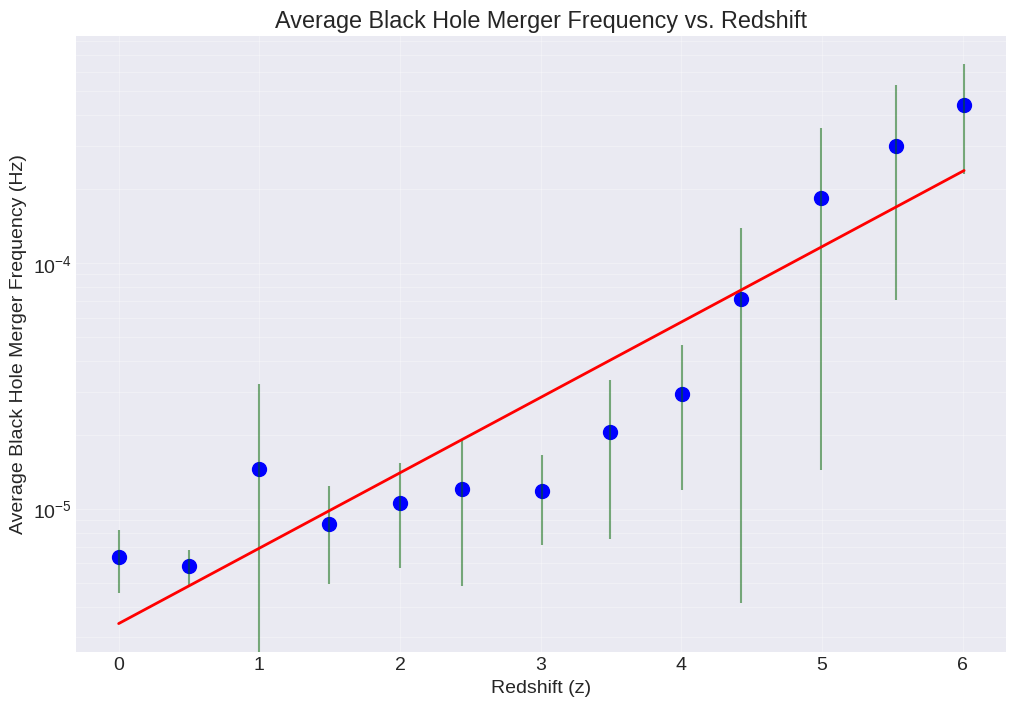

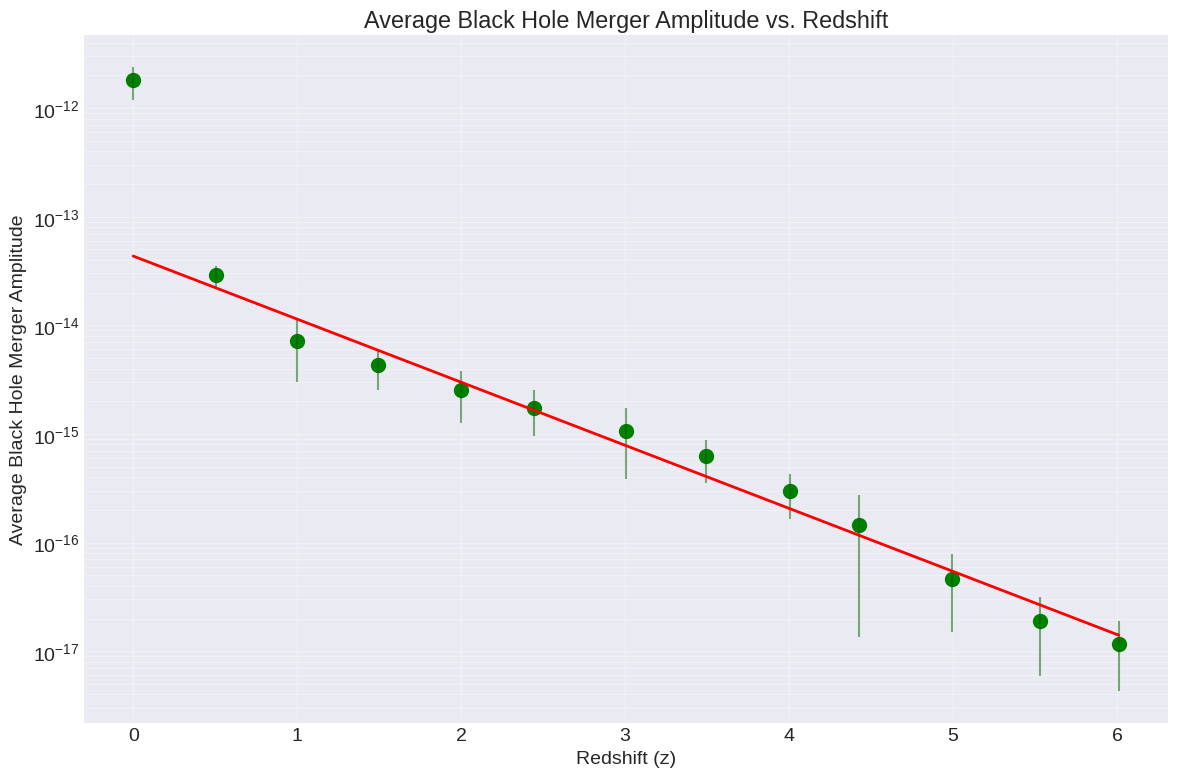

In [11]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams


baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key": "128de4248c745e040927ee558a9bcd62"}

def get(path, params=None):
    r = requests.get(path, params=params, headers=headers)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json()

    return r

# frequenct function
def frequency(m1, m2, z):

    m = m1 + m2
    return 3.9 * ((10**4) / m) * (1 / (1 + z))

# Amplitude function
def amplitude(m1, m2, z):

    h = 0.5  # hubble parameter
    e = 0.1
    f = frequency(m1, m2, z)
    x = m2 / m1

    # Makes sure the formula doesnt divide by 0
    if z < 0.01:
        z_calc = 0.01
    else:
        z_calc = z

    return (3.4E-22)*(h/0.5)*((f*1E3)**(2/3))*((m1/1E4)**(5/3))*(x/((1+x)**(1/3)))*(1/(1-((1+z_calc)**-.5)))

def main():

    r = get(baseUrl)
    names = [sim['name'] for sim in r['simulations']]

    try:
        i = names.index('TNG100-1')
        sim_name = 'TNG100-1'
    except ValueError:
        i = names.index('Illustris-1')
        sim_name = 'Illustris-1'

    sim = get(r['simulations'][i]['url'])

    snaps = get(sim['url'] + 'snapshots/')

    # Redshifts are 0 to 6 by 0.5
    redshift_bins = np.arange(0, 6.5, 0.5)

    # Finds the snapshots that are cloest to those red shifts because some snapshots dont exist for exact red shfits
    selected_snaps = []
    for z in redshift_bins:
        closest_snap = min(snaps, key=lambda s: abs(s['redshift'] - z))
        selected_snaps.append(closest_snap)

    # Loops through 10 most massive galaxies because time is of the essence!
    params = {'limit': 10, 'order_by': '-mass_stars'}

    # stores redshift data
    redshift_data = {
        'redshift': [],         # redshift value
        'avg_frequency': [],    # avg frequency
        'std_frequency': [],    # standard deviation of frequency to help understand data and debug
        'avg_amplitude': [],    # avg amplitude
        'std_amplitude': [],    # standard deviation of frequency to help understand data and debug
        'num_bhs': []           # how many bhs were found
    }

    all_redshifts = []
    all_frequencies = []
    all_amplitudes = []

    for snapshot in selected_snaps:
        z = snapshot['redshift']
        print(f"\nCurrently on z = {z:.3f} using (snapshot {snapshot['number']}):")

        # get subhalos
        subhalos = get(snapshot['url'] + 'subhalos/', params)

        # get frequencies and amplitudes for this redshift
        frequencies = []
        amplitudes = []

        # go through subhalos
        for i, subhalo in enumerate(subhalos['results']):
            # get subhalo data
            sub_detail = get(subhalo['url'])

            # find bh in the subhalo if there is one
            if 'mass_bhs' in sub_detail and sub_detail['mass_bhs'] > 0:
                bhm = sub_detail['mass_bhs'] * 1E10  # solar masses conversion

                merger_ratio = np.random.uniform(0.1, 0.5)
                m1 = bhm
                m2 = bhm * merger_ratio

                if m1 > 0:
                    f = frequency(m1, m2, z)
                    a = amplitude(m1, m2, z)

                    frequencies.append(f)
                    amplitudes.append(a)


                    all_redshifts.append(z)
                    all_frequencies.append(f)
                    all_amplitudes.append(a)

        #get mean for data per redshift
        if frequencies:
            avg_freq = np.mean(frequencies)
            std_freq = np.std(frequencies)
            avg_amp = np.mean(amplitudes)
            std_amp = np.std(amplitudes)

            redshift_data['redshift'].append(z)
            redshift_data['avg_frequency'].append(avg_freq)
            redshift_data['std_frequency'].append(std_freq)
            redshift_data['avg_amplitude'].append(avg_amp)
            redshift_data['std_amplitude'].append(std_amp)
            redshift_data['num_bhs'].append(len(frequencies))


        else:
            print("No bH")

    for key in redshift_data:
        redshift_data[key] = np.array(redshift_data[key])

    # 1. avg freq vs. redshift
    plt.figure(figsize=(12, 8))

    # Plot at each redshift
    plt.scatter(redshift_data['redshift'], redshift_data['avg_frequency'],
                s=100, color='blue', zorder=2)

    plt.errorbar(redshift_data['redshift'], redshift_data['avg_frequency'],
                yerr=redshift_data['std_frequency'], fmt='none', ecolor='darkgreen', alpha=0.5)
    # best fit
    if len(redshift_data['redshift']) > 1:
        z_range = np.linspace(min(redshift_data['redshift']), max(redshift_data['redshift']), 100)

        coeffs = np.polyfit(redshift_data['redshift'], np.log10(redshift_data['avg_frequency']), 1)
        poly = np.poly1d(coeffs)

        fitted_curve = 10**(poly(z_range))
        plt.plot(z_range, fitted_curve, 'r-', linewidth=2)

    plt.yscale('log')
    plt.xlabel('Redshift (z)')
    plt.ylabel('Average Black Hole Merger Frequency (Hz)')
    plt.title('Average Black Hole Merger Frequency vs. Redshift')
    plt.grid(True, which='both', alpha=0.3)

    # avg amplitude vs z
    plt.figure(figsize=(12, 8))

    plt.scatter(redshift_data['redshift'], redshift_data['avg_amplitude'],
                s=100, color='green', zorder=2)

    plt.errorbar(redshift_data['redshift'], redshift_data['avg_amplitude'],
                yerr=redshift_data['std_amplitude'], fmt='none', ecolor='darkgreen', alpha=0.5)

    if len(redshift_data['redshift']) > 1:
        mask = redshift_data['redshift'] > 0.1
        if mask.any():
            z_fit = redshift_data['redshift'][mask]
            amp_fit = redshift_data['avg_amplitude'][mask]

            z_range = np.linspace(min(redshift_data['redshift']), max(redshift_data['redshift']), 100)

            if len(z_fit) > 1:
                coeffs = np.polyfit(z_fit, np.log10(amp_fit), 1)
                poly = np.poly1d(coeffs)

                fitted_curve = 10**(poly(z_range))
                plt.plot(z_range, fitted_curve, 'r-', linewidth=2)

    plt.yscale('log')
    plt.xlabel('Redshift (z)')
    plt.ylabel('Average Black Hole Merger Amplitude')
    plt.title('Average Black Hole Merger Amplitude vs. Redshift')
    plt.grid(True, which='both', alpha=0.3)
    plt.tight_layout()
    plt.savefig('avg_amplitude_vs_redshift.png')

if __name__ == "__main__":
    main()